In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from pathlib import Path
import pandas as pd

import json
import logging
from pathlib import Path
from copy import deepcopy

import cv2
import numpy as np

import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import pandas as pd
from typing import Dict, Any, List
from matplotlib.lines import Line2D

In [2]:
# CONFIGURATION
COCO_JSON        = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json")
IMAGES_DIR       = Path("../data/rotation/batches/rotation_20250721_01/images/default/")
PRED_JSON        = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_predicted.json")
COCO_5OBB       = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_updated.json")
CHECKPOINT_PATH = Path("checkpoints/best_model.pth")

BATCHES_DIR = Path("../data/rotation/batches/")

In [3]:
def coco_to_df(coco: Dict[str, Any]) -> pd.DataFrame:
    img_lookup = {img['id']: img for img in coco['images']}
    rows = []
    for ann in coco['annotations']:
        img = img_lookup[ann['image_id']]
        row = {
            'image_id': ann['image_id'],
            'file_name': img['file_name'],
            'width': img['width'],
            'height': img['height'],
            'category_id': ann['category_id'],
            'bbox': ann['bbox'],
            'area': ann.get('area', None),
            'rotation': ann.get('attributes', {}).get('rotation', 0.0),
            'iscrowd': ann.get('iscrowd', 0)
        }
        rows.append(row)
    return pd.DataFrame(rows)

In [4]:

def load_coco(json_path: Path) -> Dict[str, Any]:
    with open(json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)
        print(f"coco{coco}")
    return coco

In [6]:
coco = load_coco(COCO_5OBB)


df = coco_to_df(coco)
display(df.head(5))   

coco{'licenses': [{'name': '', 'id': 0, 'url': ''}], 'info': {'contributor': '', 'date_created': '', 'description': '', 'url': '', 'version': '', 'year': ''}, 'categories': [{'id': 1, 'name': 'infoBlock', 'supercategory': ''}, {'id': 2, 'name': 'isOk', 'supercategory': ''}, {'id': 3, 'name': 'surface-roughness', 'supercategory': ''}, {'id': 4, 'name': 'infoblock', 'supercategory': ''}, {'id': 5, 'name': 'additional infoblock', 'supercategory': ''}, {'id': 6, 'name': 'additional-infoblock', 'supercategory': ''}, {'id': 7, 'name': 'welding_symbol', 'supercategory': ''}, {'id': 8, 'name': 'inner-edge-', 'supercategory': ''}, {'id': 9, 'name': 'text', 'supercategory': ''}, {'id': 10, 'name': 'gdt', 'supercategory': ''}, {'id': 11, 'name': 'inner-edge-tolerance', 'supercategory': ''}, {'id': 12, 'name': 'drawing-area', 'supercategory': ''}, {'id': 13, 'name': 'general-chamfer', 'supercategory': ''}], 'images': [{'id': 1, 'width': 3057, 'height': 2160, 'file_name': '7435.png', 'license': 0, 

image_id file_name  width  height  category_id  \
0         1  7435.png   3057    2160            9   
1         1  7435.png   3057    2160            9   
2         1  7435.png   3057    2160            9   
3         1  7435.png   3057    2160            9   
4         1  7435.png   3057    2160            9   

                                                bbox       area  rotation  \
0             [1222.64, 436.06, 42.0, 31.28, 269.96]   1313.760    269.96   
1               [1332.32, 1041.25, 16.96, 26.9, 0.0]    456.224      0.00   
2      [1499.4399999999998, 243.77, 13.7, 26.5, 0.0]    363.050      0.00   
3  [2457.735, 1100.6299999999999, 665.95, 34.72, ...  23121.784      0.00   
4   [1379.925, 1105.3500000000001, 53.35, 31.9, 0.0]   1701.865      0.00   

   iscrowd  
0        0  
1        0  
2        0  
3        0  
4        0

In [8]:
df_ann = pd.DataFrame(coco["annotations"])
df_img = pd.DataFrame(coco["images"])


In [9]:
df_ann = pd.DataFrame(coco["annotations"])
df_img = pd.DataFrame(coco["images"])




In [10]:
df_ann.head()

id  image_id  category_id segmentation       area  \
0   1         1            9           []   1313.760   
1   2         1            9           []    456.224   
2   3         1            9           []    363.050   
3   4         1            9           []  23121.784   
4   5         1            9           []   1701.865   

                                                bbox  iscrowd  \
0             [1222.64, 436.06, 42.0, 31.28, 269.96]        0   
1               [1332.32, 1041.25, 16.96, 26.9, 0.0]        0   
2      [1499.4399999999998, 243.77, 13.7, 26.5, 0.0]        0   
3  [2457.735, 1100.6299999999999, 665.95, 34.72, ...        0   
4   [1379.925, 1105.3500000000001, 53.35, 31.9, 0.0]        0   

                                attributes  
0  {'occluded': False, 'rotation': 269.96}  
1     {'occluded': False, 'rotation': 0.0}  
2     {'occluded': False, 'rotation': 0.0}  
3     {'occluded': False, 'rotation': 0.0}  
4     {'occluded': False, 'rotation': 0.0}

In [11]:
df_img.head()

id  width  height file_name  license flickr_url coco_url  date_captured
0   1   3057    2160  7435.png        0                                  0
1   2   3054    2160  7443.png        0                                  0
2   3   2160    3054  7445.png        0                                  0
3   4   2160    3055  7451.png        0                                  0
4   5   3338    2160  7459.png        0                                  0

In [16]:
img_row = df_img.iloc[1]


In [ ]:
img_row.head()

id                  2
width            3054
height           2160
file_name    7443.png
license             0
Name: 1, dtype: object

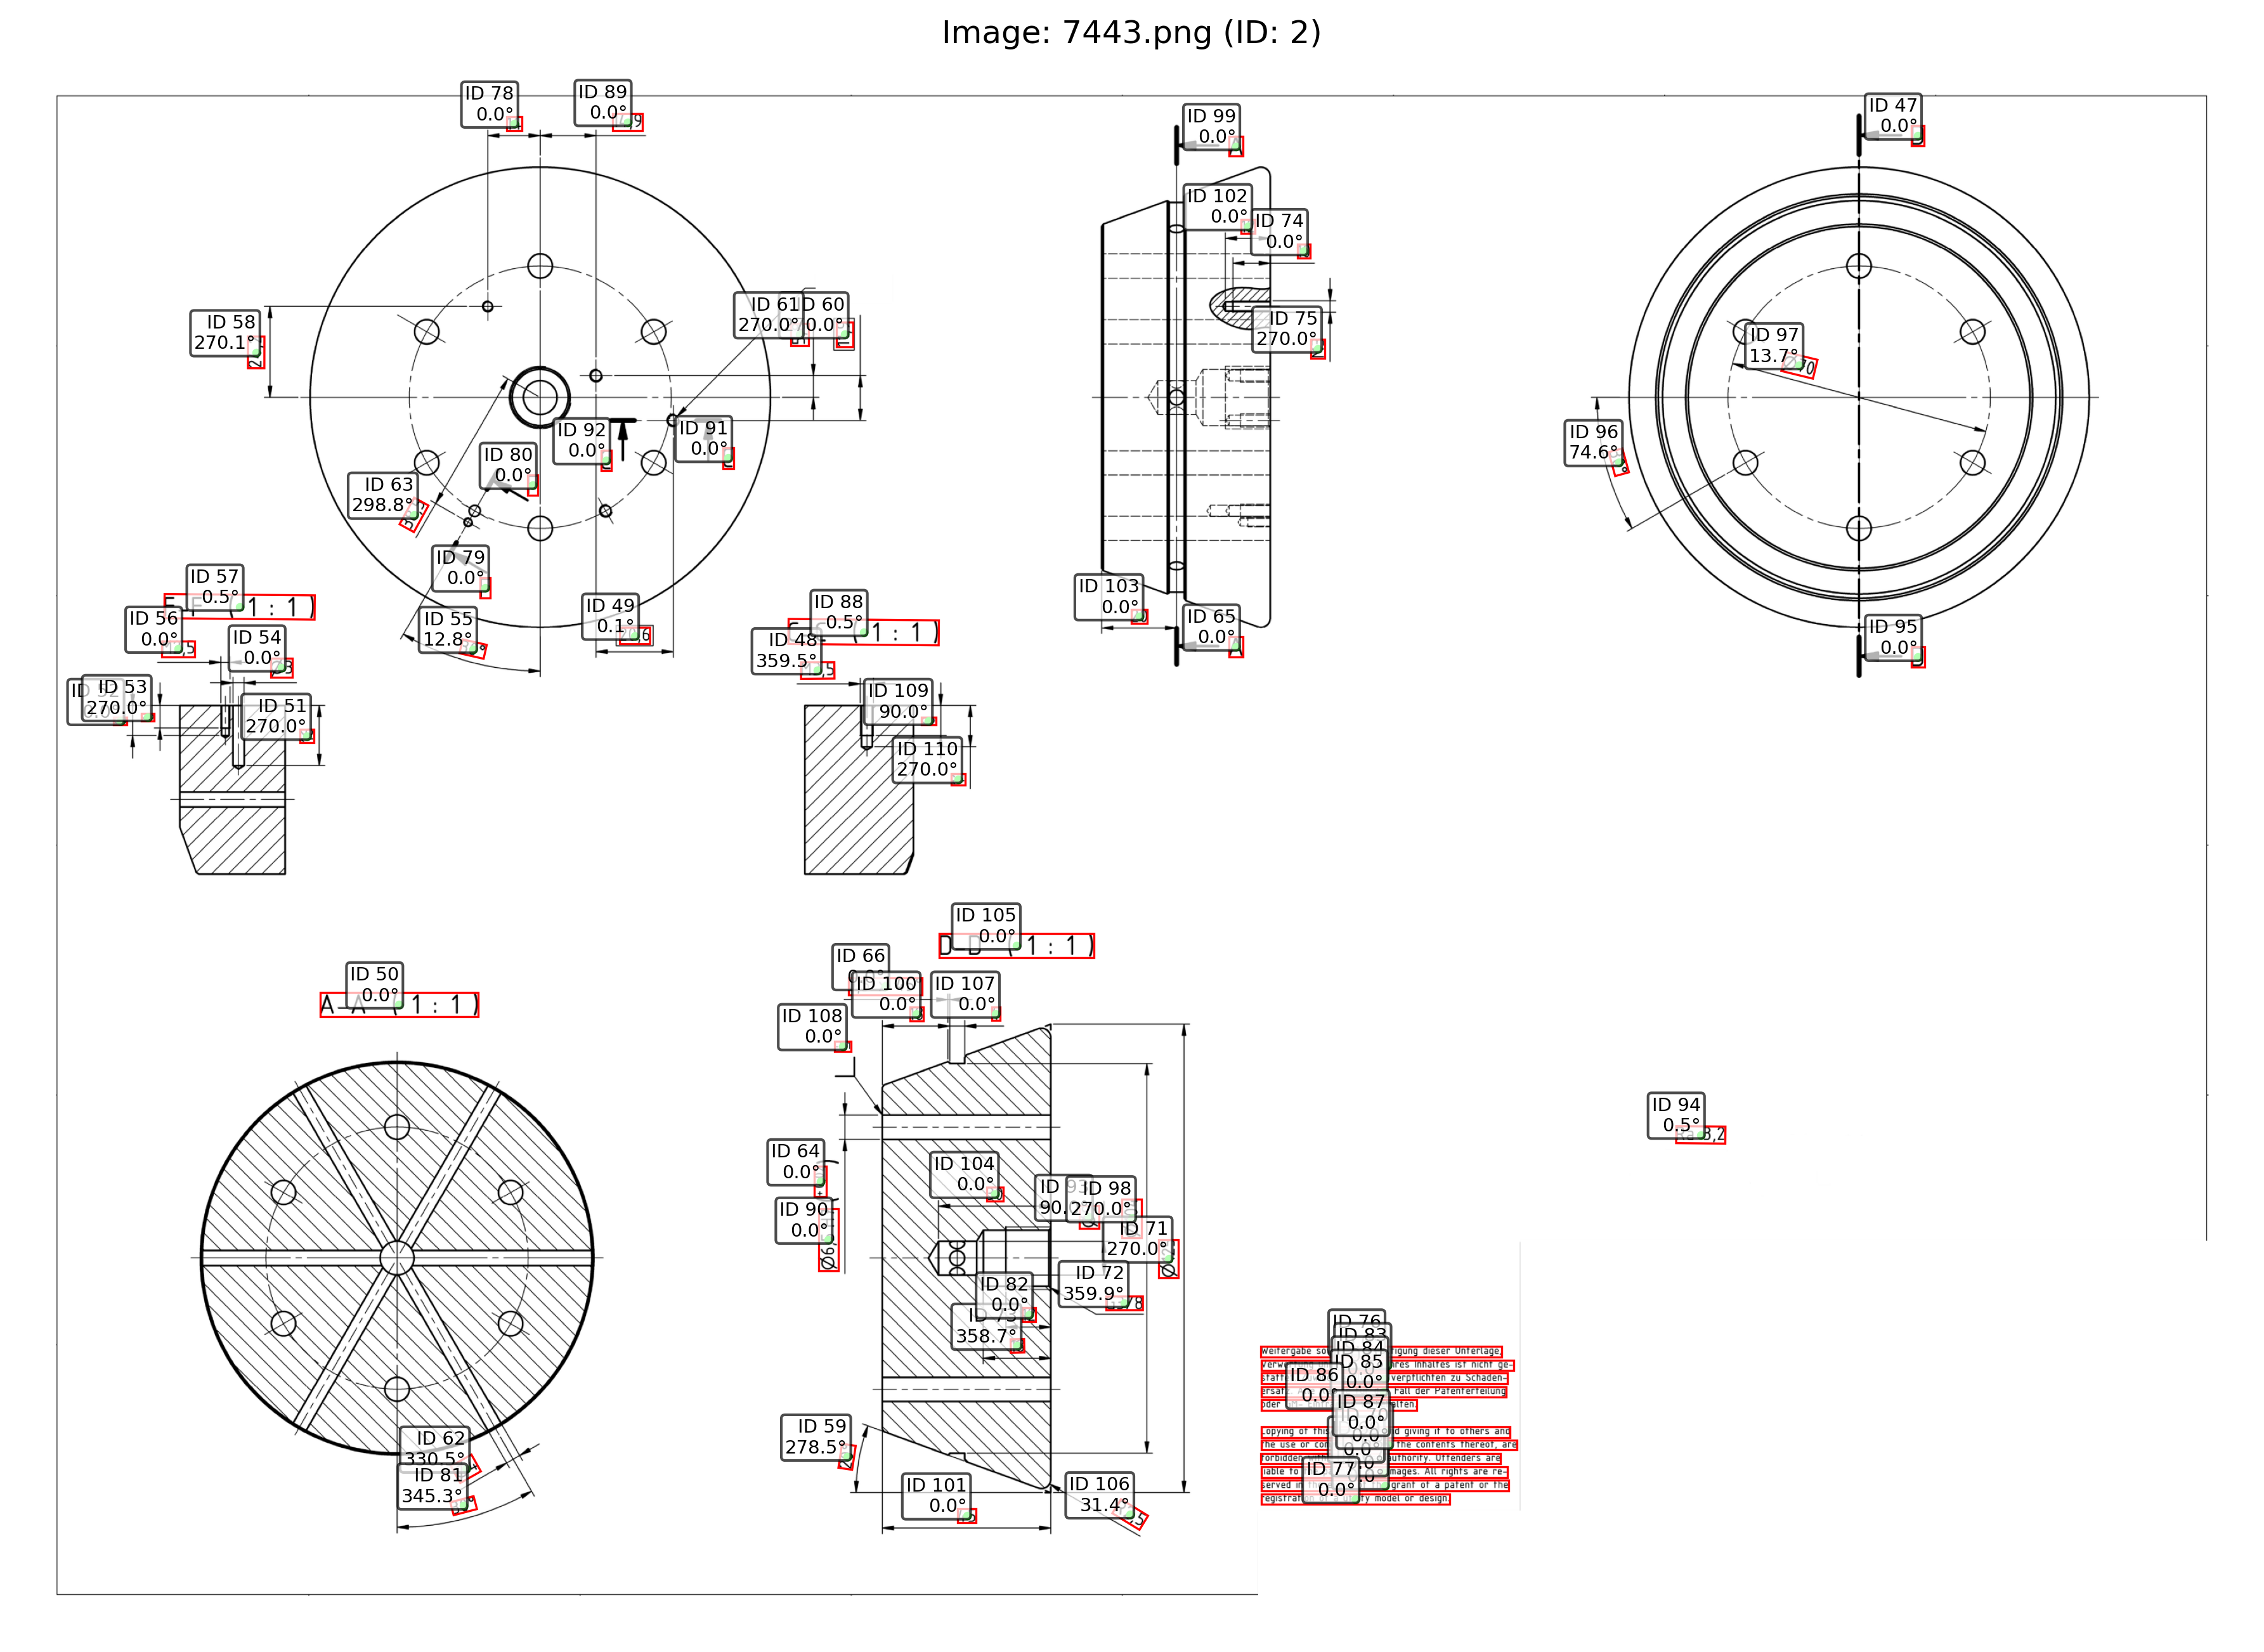

In [19]:


def show_crops_with_ids_and_rotations(image_row: pd.Series,
                                      annotations_df: pd.DataFrame,
                                      images_dir: Path,
                                      show_centers: bool = True) -> None:
    """
    Displays an image with rotated bounding boxes. Each box is labeled with its annotation ID and rotation.
    
    Parameters:
        image_row: A row from df_img with at least "id" and "file_name".
        annotations_df: DataFrame with columns ["image_id", "bbox", "rotation", "id"].
        images_dir: Directory containing the image files.
        show_centers: Whether to show the center point of each box.
    """
    img_path = images_dir / image_row["file_name"]
    if not img_path.exists():
        print(f"Image not found: {img_path}")
        return

    # Load image
    img = plt.imread(img_path)
    fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
    ax.imshow(img)
    ax.set_title(f'Image: {image_row["file_name"]} (ID: {image_row["id"]})')
    ax.axis("off")

    # Filter annotations for this image
    anns = annotations_df[annotations_df["image_id"] == image_row["id"]]

    for _, ann in anns.iterrows():
        cx, cy, w, h, angle = ann["bbox"]
        ann_id = ann["id"]


        # Draw rotated rectangle
        rect = Rectangle((cx - w / 2, cy - h / 2), w, h,
                         linewidth=0.8, edgecolor="red", fill=False)
        trans = Affine2D().rotate_deg_around(cx, cy, angle) + ax.transData
        rect.set_transform(trans)
        ax.add_patch(rect)

        # Annotate with ID and rotation
        ax.text(cx, cy, f"ID {ann_id}\n{angle:.1f}°",
                color="black", fontsize=7, ha="right", va="bottom",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.7))

        # Optionally draw the center
        if show_centers:
            ax.scatter(cx, cy, color="lime", s=5, zorder=2)

    plt.tight_layout()
    plt.show()


show_crops_with_ids_and_rotations(img_row, df_ann, IMAGES_DIR)